# TROUT Examples Notebook
This notebook shows how to use the TROUT code to produce figures and analyze demagnetization data. Each "cell" in this notebook runs a block of code which gives an example of using TROUT to analyze an experiment. 

### Required Packages
TROUT requires you to have the packages `numpy`, `scipy`, `matplotlib`, `pandas`, `jax` ,`sklearn`, `emcee` and `pmagpy` installed. Of these, `jax` does not currently support windows but can be installed under Windows Subsystem for Linux.

In [4]:
import trout as tr

### Importing MagIC formatted data.
TROUT imports and converts data from the MagIC format using the `import_direction_data` function, which takes in a folder as an argument. Let's import some data from the `PD22` dataset.

In [59]:
meas_data,sample_data,site_data=tr.import_direction_data('PD22/')

`meas_data`,`sample_data` and `site_data` represent the measurements, samples and sites tables respectively.  

### Converting data to a format TROUT uses
The `prepare_specimen_data()` function takes in a specimen name and the measurement and these three tables. Let's take a peek at sample `PD014d2`:

In [60]:
specimen='PD014d2'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=tr.prepare_specimen_data(specimen,meas_data,sample_data,site_data)

This function returns numerous things:  
`zijd_data`: An array of the demagnetization data vectors.  
`Ts_base`: An array of the treatment temperatures (or coercivities) for each data point  
`Ts_data`: An array of the treatment temperatures scaled according to some exponent `expon`.  
`Ts`: Interpolated treatment temperatures  
`datatype`:either `thermal` or `AF` depending on kind of treatment  
`expon`: the exponent used to scale the temperatures.  

If you would prefer not to scale the data, you can use the argument `normalize=False` in this function (not recommended).

### Running the TROUT model
The TROUT model is run using the `find_best_fit_model()` function. This takes in the `zijd_data` and `Ts_data` arrays and finds a model for the blocking temperature distributions, directions and magnitudes for each component, specifying a number of components using the `n_components` argument. The function also has some additional arguments described in the docstring. Only the first three arguments should ever be used as options to ensure a good fit with TROUT, others should generally be left alone.

In [61]:
help(tr.find_best_fit_model)

Help on function find_best_fit_model in module trout:

find_best_fit_model(zijd_data, Ts_data, n_components, anchored=False, init_scale=0.1, pop_size=2, polish=True, post_func=<PjitFunction of <function post_func_sigma_psi at 0x7fcee8e7bee0>>, use_grad=False, bpoints=None)
    Finds the best fitting model to the data using the BFGS method.
    
    zijd_data: nx3 array
    Set of demagnetization data the TROUT model will be applied to
    
    Ts_data: length n array
    Scaled Temperature steps or coercivities
    
    n_components: int
    number of components (k) in model.
    
    anchored: bool
    When True, performs the TROUT fit to all data. TROUT assumes that at high
    temperatures, the magnetization goes to zero. With Anchored=False, the 
    origin is moved to the final demagnetization step so this requirement is
    not met. With Anchored=True an additional component may be needed for 
    specimens where the magnetization does not trend towards the origin.
    
    init_

In [62]:
par_dict,alt_par_dicts=tr.find_best_fit_model(zijd_data,Ts_data,n_components=2)

29 of 32 minimizations successful
Best result has a log probability score of 194.2


The statistics presented here tell a number of minimizations which were successful and the log posterior probability density score of the best result. 
The model produces a dictionary containing the best fitting set of parameters to the TROUT model, which we call `par_dict`. It also produces a list of dictionaries called `alt_par_dict` which give the parameters for results with lower posterior probabilities. To get an idea of the structure, we can take a look at one of these dictionaries:

In [63]:
par_dict

{'Ms': Array([[-0.080965266,  0.5494416  , -0.061921053],
        [ 0.13345379 , -0.13558301 ,  0.94465137 ]], dtype=float32),
 'mus': Array([2.7009437, 6.1047735], dtype=float32),
 'p_stars': Array([1.0306659, 1.0578736], dtype=float32),
 'psi': Array(0.013282221, dtype=float32),
 'q_stars': Array([-1.0232433 ,  0.35966906], dtype=float32),
 'sds': Array([1.6156961, 1.4695044], dtype=float32),
 'sigma': Array(0.009193835, dtype=float32),
 'Bs': Array([[-0.14488709,  0.9832239 , -0.11080752],
        [ 0.13849247, -0.14070208,  0.98031765]], dtype=float32),
 'cs': array([0.5588163, 0.9636176], dtype=float32),
 'logp': 194.21363830566406}

### Plotting Results from the TROUT model
Results for TROUT are plotted using the `plot_results` function. This takes in several of the parameters we've mentioned previously and plots the TROUT model. Note that for this function, there are several optional arguments.

In [64]:
help(tr.plot_results)

Help on function plot_results in module trout:

plot_results(zijd_data, Ts_base, Ts_data, par_dict, expon, anchored=False, shared_axis=0, ax=None, hide_xlabel=False, inset_loc='upper left')
    Plots TROUT model on Zijderveld plot, SGG distributions and equal area plot.
    
    Inputs
    ------
    zijd_data: nx3 array
    Set of Zijderveld data for 
    
    Ts_base: length n array
    Original Temperature steps (or coercivities).
    
    Ts_data: length n array
    Scaled Temperature steps or coercivities
    
    par_dict: dict
    Dictionary of TROUT parameters
    
    expon: float
    exponent to scale data by. If expon > 0 then
    data are scaled by their distance from the 
    highest temperature/field.
    
    anchored: bool
    When True, performs the TROUT fit to all data. TROUT assumes that at high
    temperatures, the magnetization goes to zero. With Anchored=False, the 
    origin is moved to the final demagnetization step so this requirement is
    not met. With An

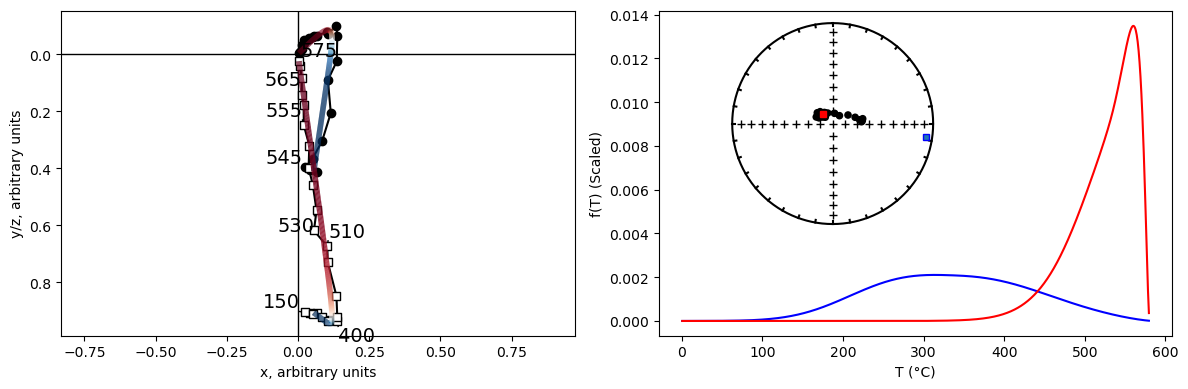

In [65]:
tr.plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon)

Oh no, our Zijderveld plot is hard to read, as we're mostly spreading out along the y and z axes! Let's change the `shared axis` argument to `1` to swap the y and x axes.

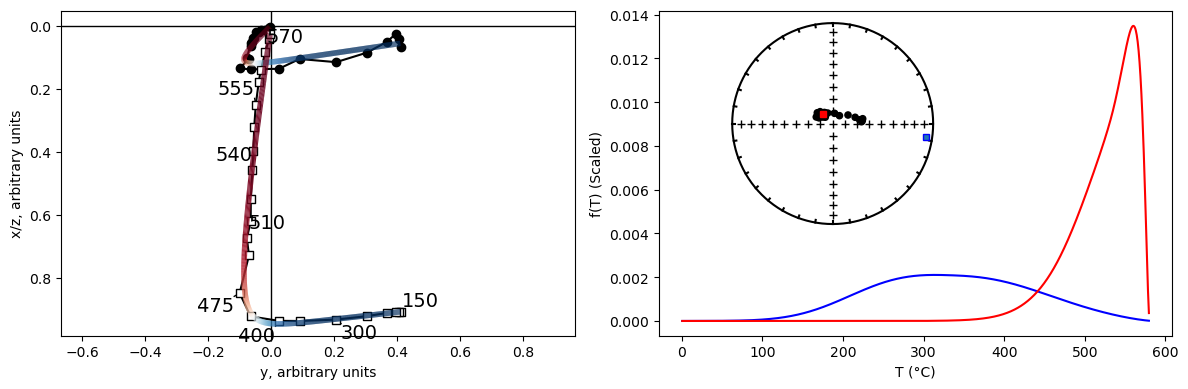

In [66]:
tr.plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,shared_axis=1)

Much better. The colors on the Zijderveld plot represent the dominant component, with lighter colors being indicative of overlap between the two components. The right plot shows the unblocking temperature distribution of each component, with an inset stereonet showing the expected directions. TROUT suggests that there may be overlap between the high and low temperature components between 400 and 475$^{\circ}$C

### Extracting the crossover temperature and multi-component region.
We can get an estimate of the crossover temperatures and mixed regions for this specimen using the `calc_overlap_range` function, which takes the `Ts_base` and `expon` arguments as well as the TROUT solution in `par_dict`

In [67]:
pdfs,crossovers,lowers,uppers=tr.calc_overlap_range(par_dict,Ts_base,expon)

Our crossover temperatures (i.e. the "corner" temperature of the Zijderveld plot) is in the `crossovers` array. `crossovers[i,j]` gives the crossover point between the ith and jth component. Typically `crossovers[i,j]=crossovers[j,i]`. Let's have a look for this specimen.

In [68]:
crossovers

array([[              nan, 441.3371337133713],
       [441.3371337133713,               nan]])

TROUT thinks the crossover temperature is around 440$^\circ$C

The `lowers` array gives the lower bounds of the overlapping regions. `lowers[i,i]` gives the region over which only the ith component is unblocking, whereas `lowers[i,j]` gives the region over which the ith and jth component are both unblocking (the mixed region). The `uppers` array gives the upper bounds of each of these regions in the same way.

In [69]:
lowers,uppers

(array([[112.06720672067206, 371.58515851585156],
        [579.7099709970997 , 521.1821182118211 ]]),
 array([[371.58515851585156, 521.1821182118211 ],
        [579.9419941994199 , 579.7099709970997 ]]))

According to the result we got here, the low temperature component unblocks between around 100 and 375$^\circ$C, the high temperature component unblocks between around 520 and 580$^\circ$C and both components unblock between around 375 and 520$^\circ$C. Note that these numbers are accurate to around one temperature step, so you might get slightly different ones each time you run TROUT. Note that the `[j,i]` index may not always equal the `[i,j]` index due to crossover at the minimum or maximum temperature. 

This specification might be confusing, but presenting these temperatures as an array becomes much simpler when you remember that TROUT . Remember to always read the docstring if you're confused

### Data with more components
TROUT can be applied to data with any number of components. We can test it on another specimen with three components:

24 of 46 minimizations successful
Best result has a log probability score of 212.4


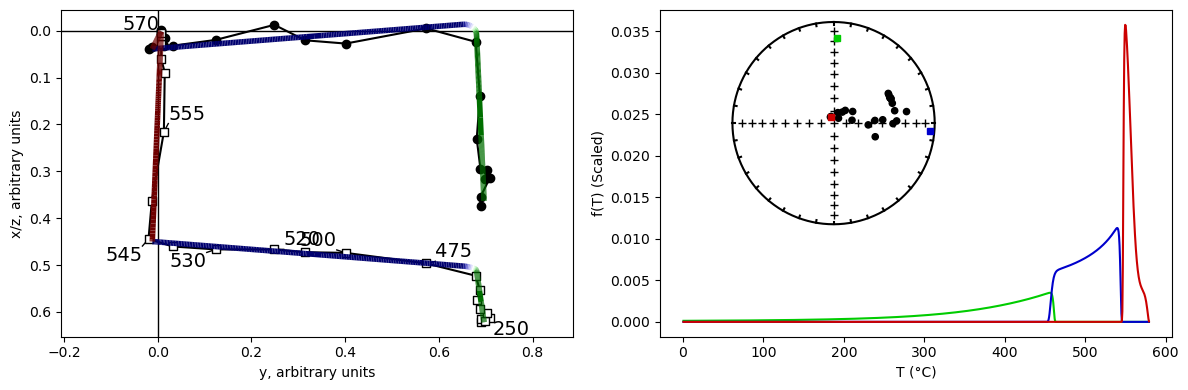

In [42]:
specimen='PD036a1'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=tr.prepare_specimen_data(specimen,meas_data,sample_data,site_data)
par_dict,alt_par_dicts=tr.find_best_fit_model(zijd_data,Ts_data,n_components=3)
tr.plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,shared_axis=1)

We can also demonstrate the overlap arrays for this specimen, demonstrating how these are necessary with three components.

In [44]:
pdfs,crossovers,lowers,uppers=tr.calc_overlap_range(par_dict,Ts_base,expon)
crossovers,lowers,uppers

(array([[               nan, 458.15881588158817, 501.98219821982195],
        [458.15881588158817,                nan, 545.8055805580558 ],
        [501.98219821982195, 545.8055805580558 ,                nan]]),
 array([[4.060406040604060e-01, 4.543594359435943e+02,
         4.581298129812981e+02],
        [4.543594359435943e+02, 4.623062306230623e+02,
         5.455445544554456e+02],
        [4.581298129812981e+02, 5.455445544554456e+02,
         5.461246124612461e+02]]),
 array([[454.35943594359435, 462.3062306230623 , 545.8345834583458 ],
        [462.3062306230623 , 545.5445544554456 , 546.1246124612461 ],
        [545.8345834583458 , 546.1246124612461 , 579.2459245924592 ]]))

### AF demagnetization data

TROUT can also be applied to AF demagnetization data, for example:
The axis labels for the coercivity distribution need to be changed manually currently.

22 of 32 minimizations successful
Best result has a log probability score of 143.9


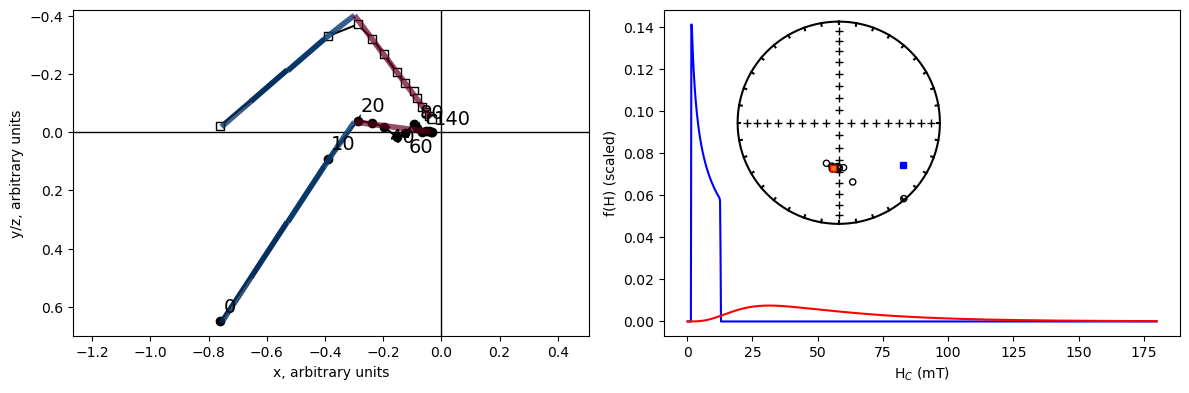

In [55]:
import matplotlib.pyplot as plt

meas_data,sample_data,site_data=tr.import_direction_data('SFVolc/')

specimen='sv18i1'
zijd_data,Ts_base,Ts_data,Ts,datatype,expon=tr.prepare_specimen_data(specimen,meas_data,sample_data,site_data)
par_dict,alt_par_dicts=tr.find_best_fit_model(zijd_data,Ts_data,n_components=2)
fig,ax=plt.subplots(1,2,figsize=(12,4))
tr.plot_results(zijd_data,Ts_base,Ts_data,par_dict,expon,ax=ax)
ax[1].set_xlabel('H$_{C}$ (mT)')
ax[1].set_ylabel('f(H) (scaled)');

### Writing to file
TROUT can automatically output results to the MagIC files using the `TROUT_write()` function. This performs the analysis and writes the result

In [ ]:
specimen='sv18i1'
tr.TROUT_write('SFVolc/',specimen,n_components,pop_size=4)